In [1]:
# =============================================================================
# 1. IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import re
import time
import multiprocessing

# Sklearn & related imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay) # <-- ADDED for detailed metrics

# Other libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Visualization libraries  <-- ADDED
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# =============================================================================
# 2. CONFIGURATION CONTROLS
# =============================================================================
# --- Adjust these variables to control the trade-off between speed and accuracy ---

# ⚙️ Fraction of data to use. (e.g., 1.0 for all data, 0.25 for a quick 25% sample)
DATA_SAMPLE_FRAC = 0.25

# ⚙️ Number of splits for TimeSeriesSplit cross-validation. (e.g., 5 for robust, 3 for fast)
CV_SPLITS = 2

# ⚙️ Number of parameter combinations to try in RandomizedSearchCV. (e.g., 30 for thorough, 10 for fast)
N_ITER_SEARCH = 5

# ⚙️ CPU Usage Limit Control
CPU_USAGE_PERCENT = 0.50  # Set desired usage (e.g., 0.50 for 50%, 0.75 for 75%)
TOTAL_CORES = multiprocessing.cpu_count()
# Calculate the number of cores to use, ensuring it's at least 1
print('Your PC has', TOTAL_CORES, 'cores')
N_JOBS_LIMIT = max(1, int(TOTAL_CORES * CPU_USAGE_PERCENT))

print(
    f"--- System has {TOTAL_CORES} cores. Limiting parallel jobs to {N_JOBS_LIMIT} ({CPU_USAGE_PERCENT * 100:.0f}%) ---")

# Load data
# Make sure the path to your CSV file is correct
try:
    df_weather2 = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfCancel', 'DateOfService'])
    display(Markdown("## Data Successfully Loaded"))
    display(df_weather2.head(3))
except FileNotFoundError:
    print("Error: The data file 'df_weather3.csv' was not found. Please ensure the file path is correct.")
    exit() # Exit if data can't be loaded


# =============================================================================
# 3. CUSTOM TRANSFORMER DEFINITIONS
# =============================================================================
# NOTE: The custom transformers remain unchanged from your original script.

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean', 'count'])
            agg['enc'] = ((agg['count'] * agg['mean'] + self.smoothing * self.global_mean_) / (
                        agg['count'] + self.smoothing))
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c].map(self.mapping_.get(c)).fillna(self.global_mean_)
        return X


class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site', 'MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col = value_col
        self.out_col = out_col

    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_ = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self

    def transform(self, X):
        keys = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X


class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site', 'MenuBase'), n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys = group_keys
        self.n_clusters = n_clusters
        self.out_col = out_col

    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10).fit(scaled)
        tuples = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_ = int(np.median(self.kmeans_.labels_))
        return self

    def transform(self, X):
        X = X.copy()
        keys = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X


class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy

    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        clean = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self

    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')


class FeatureNameSanitizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()
        df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
        return df

# =============================================================================
# 4. VIF CHECK
# =============================================================================
display(Markdown("--- \n ## 4. VIF (Multicollinearity) Check"))
print("--- Starting VIF Check ---")
num_cols = df_weather2.select_dtypes(include=[np.number]).columns.to_list()
drop_col = ['DateOfOrder', 'DateOfService', 'days_to_cancel', 'CanceledQty', 'OrderId', 'TransactionId',
            'cancel_timing', 'BookingNr', 'DateOfCancel', 'net_qty']
vif_col_1 = [c for c in num_cols if c not in drop_col]

vif_dat_1 = df_weather2[vif_col_1].copy()
vif_dat_1.replace([np.inf, -np.inf], np.nan, inplace=True)
vif_dat_1 = vif_dat_1.dropna()

vif_scores_1 = [variance_inflation_factor(vif_dat_1.values, i) for i in range(vif_dat_1.shape[1])]
vif_table_1 = (
    pd.DataFrame({'feature': vif_col_1, 'VIF': vif_scores_1}).sort_values('VIF', ascending=False).reset_index(
        drop=True))

display(Markdown("### VIF Scores for Numeric Features"))
print("VIF measures how much a feature is explained by other features. A score > 10 often indicates high multicollinearity.")
display(vif_table_1.head(10))

hg_vif_1 = vif_table_1.loc[vif_table_1['VIF'] > 10, 'feature'].to_list()
print('\nHigh VIF columns to be aware of (or drop):')
print(hg_vif_1)


Your PC has 10 cores
--- System has 10 cores. Limiting parallel jobs to 5 (50%) ---


## Data Successfully Loaded

,Unnamed: 0,DateOfOrder,OrderId,TransactionId,DateOfService,OrderQty,MenuName,MenuPrice,MenuSubsidy,BookingNr,...,morning,afternoon,evening,hist_cancel_rate,is_holiday,tavg_C,prcp_mm,rain_flag,temp_dev,cancel_timing
0,0,2019-12-02 20:39:46,11161800,5fff5813ae674809a06e3b1fe5528fcf,2020-01-02,1,Mittagessen (BS),3.05,0.0,474-136052114,...,0,0,1,1.0499,0,0.3,0.0,0,-3.965782,no_cancel
1,1,2019-12-02 20:39:46,11161801,7c4f0e97356e46669abefe8dc5fb0ff0,2020-01-03,1,Mittagessen (BS),3.05,0.0,474-136052114,...,0,0,1,1.0499,0,6.7,4.9,1,2.434218,no_cancel
2,2,2019-12-03 22:29:24,11166739,ee1d1a4a7458414a8bb420111ba0fa8c,2020-01-02,1,Mittagessen (BS),3.05,0.0,474-136060130,...,0,0,1,1.0499,0,0.3,0.0,0,-3.965782,no_cancel


--- 
 ## 4. VIF (Multicollinearity) Check

--- Starting VIF Check ---


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### VIF Scores for Numeric Features

VIF measures how much a feature is explained by other features. A score > 10 often indicates high multicollinearity.


,feature,VIF
0,afternoon,inf
1,morning,inf
2,evening,inf
3,day_of_year,3.102898e+04
4,month,3.086469e+04
5,day_of_month,1.300759e+02
6,quarter,2.209046e+01
7,MenuSubsidy,6.593575e+00
8,MenuPrice,6.495096e+00
9,order_hour,5.359547e+00



High VIF columns to be aware of (or drop):
['afternoon', 'morning', 'evening', 'day_of_year', 'month', 'day_of_month', 'quarter']


--- 
 ## 5. Stage A: Binary Cancellation Prediction

Using a 25% sample of the data for Stage A.


### 5.1 Stage A: Data Analysis

Analyzing the target variable for Stage A: 'Was an order canceled?' (1) or 'Not Canceled' (0).


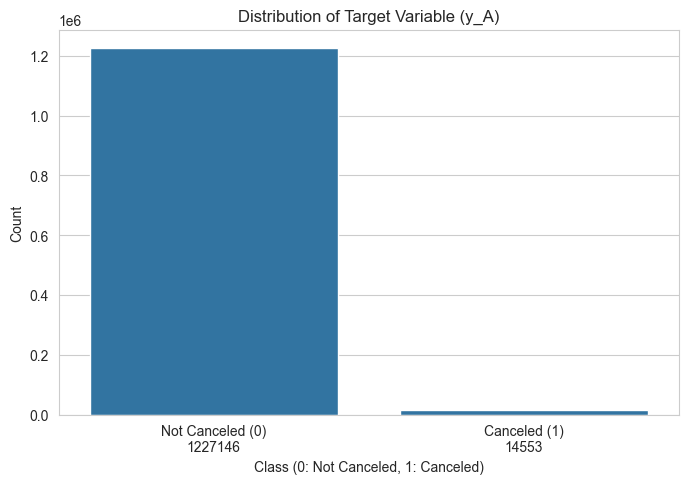

Training set size: 993359 samples
Test set size: 248340 samples


### 5.2 Stage A: LightGBM Model Training


Running Stage A with LightGBM (CV Splits=2, Search Iterations=5)...
[LightGBM] [Info] Number of positive: 3502, number of negative: 327619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 331121, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010576 -> initscore=-4.538517
[LightGBM] [Info] Start training from score -4.538517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3502, number of negative: 327619
[

### 5.3 Stage A: Model Evaluation on Hold-Out Test Set

#### Classification Report

This report shows the precision, recall, and F1-score for each class on the unseen test data.
              precision    recall  f1-score   support

Not Canceled       0.98      1.00      0.99    243254
    Canceled       0.00      0.00      0.00      5086

    accuracy                           0.98    248340
   macro avg       0.49      0.50      0.49    248340
weighted avg       0.96      0.98      0.97    248340



/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

#### Confusion Matrix

The confusion matrix visualizes model performance. It shows correct vs. incorrect predictions.


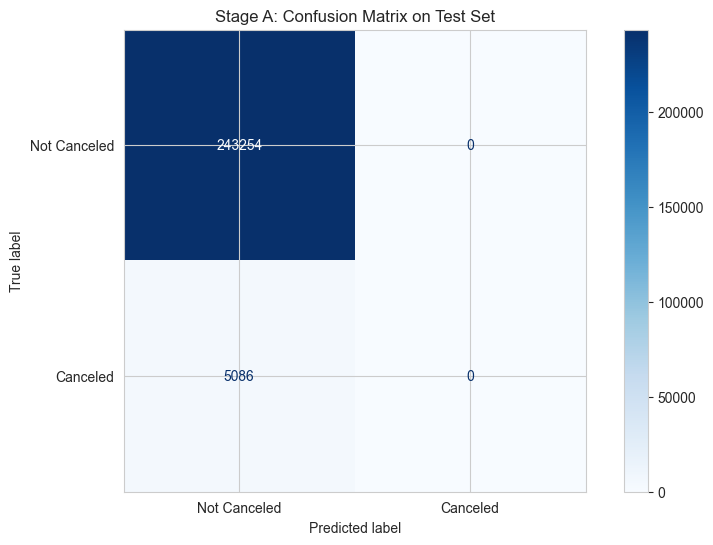

#### ROC Curve

The model's ROC AUC score on the test set is: 0.7706


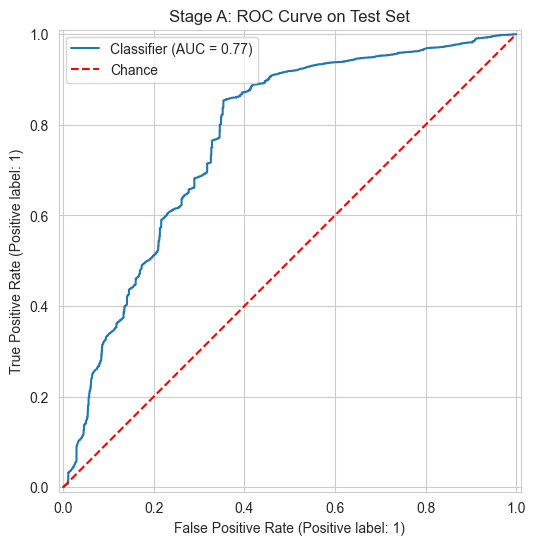

#### Feature Importance

This chart shows the most influential features for the cancellation prediction model.


ValueError: All arrays must be of the same length

In [2]:

# =============================================================================
# 5. STAGE A: CANCELLATION PREDICTION (BINARY CLASSIFICATION)
# =============================================================================
display(Markdown("--- \n ## 5. Stage A: Binary Cancellation Prediction"))
df_A = df_weather2.copy().sort_values('DateOfService').reset_index(drop=True)

# Use sample or full data based on config
if DATA_SAMPLE_FRAC < 1.0:
    print(f"Using a {DATA_SAMPLE_FRAC * 100:.0f}% sample of the data for Stage A.")
    df_A = df_A.sample(frac=DATA_SAMPLE_FRAC, random_state=42).sort_values('DateOfService').reset_index(drop=True)

y_A = (df_A['CanceledQty'] > 0).astype(int)
X_A = df_A.drop(columns=[
    'CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService', 'DateOfCancel',
    'OrderId', 'TransactionId', 'BookingNr', 'hist_cancel_rate', 'GroupName', 'SchoolID'
])

# --- 5.1 Stage A: Data Analysis ---
display(Markdown("### 5.1 Stage A: Data Analysis"))
print("Analyzing the target variable for Stage A: 'Was an order canceled?' (1) or 'Not Canceled' (0).")
plt.figure(figsize=(8, 5))
sns.countplot(x=y_A)
plt.title('Distribution of Target Variable (y_A)')
plt.xlabel("Class (0: Not Canceled, 1: Canceled)")
plt.ylabel("Count")
plt.xticks([0, 1], [f'Not Canceled (0)\n{y_A.value_counts()[0]}', f'Canceled (1)\n{y_A.value_counts()[1]}'])
plt.show()

# --- 5.2 Stage A: Train-Test Split ---
# We split the data into a training set and a final hold-out test set
# We don't shuffle to respect the time-series nature of the data
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)
print(f"Training set size: {len(X_train_A)} samples")
print(f"Test set size: {len(X_test_A)} samples")


# --- 5.3 Stage A: Model Training ---
display(Markdown("### 5.2 Stage A: LightGBM Model Training"))
profile_feats = ['hist_cancel_rate', 'rain_flag', 'temp_dev', 'sin_doy', 'cos_doy', 'month',
                 'day_of_month', 'is_month_end', 'is_month_start', 'tavg_C', 'prcp_mm']
drop_cols_A = ['Site', 'MenuBase', 'MenuName', 'GroupName', 'MenuNorm', 'MenuCode', 'net_qty', 'days_to_cancel']

base_steps_A = [
    ('te', InCVTargetEncoder(cols=['Site', 'MenuBase'], smoothing=0.3)),
    ('hist', HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(profile_feats=profile_feats, n_clusters=5)),
    ('drop', ColumnDropper(drop_cols_A)),
    ('impute', MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer())
]

tscv = TimeSeriesSplit(n_splits=CV_SPLITS)

print(f"\nRunning Stage A with LightGBM (CV Splits={CV_SPLITS}, Search Iterations={N_ITER_SEARCH})...")
start_time = time.time()
pipeline_lgbm_A = ImbPipeline(
    base_steps_A + [('clf', LGBMClassifier(objective='binary', random_state=24, n_jobs=N_JOBS_LIMIT))])

param_dist_lgbm = {
    'clf__n_estimators': [200, 500, 800],
    'clf__learning_rate': [0.01, 0.03, 0.05],
    'clf__num_leaves': [15, 31, 40],
    'clf__max_depth': [6, 10, -1],
    'clf__subsample': [0.7, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.9, 1.0],
}

search_lgbm_A = RandomizedSearchCV(
    pipeline_lgbm_A, param_distributions=param_dist_lgbm, n_iter=N_ITER_SEARCH,
    cv=tscv, scoring='roc_auc', n_jobs=N_JOBS_LIMIT, random_state=24
)
search_lgbm_A.fit(X_train_A, y_train_A) # Fit on the training data only
print(f"LGBM training finished in {time.time() - start_time:.2f} seconds.")
print(f"Best CV ROC AUC on Training Data: {search_lgbm_A.best_score_:.4f}")
print(f"Best LGBM Params: {search_lgbm_A.best_params_}")

# --- 5.4 Stage A: Model Evaluation on Test Set ---
display(Markdown("### 5.3 Stage A: Model Evaluation on Hold-Out Test Set"))
best_model_A = search_lgbm_A.best_estimator_
y_pred_A = best_model_A.predict(X_test_A)
y_proba_A = best_model_A.predict_proba(X_test_A)[:, 1]

# Classification Report
display(Markdown("#### Classification Report"))
print("This report shows the precision, recall, and F1-score for each class on the unseen test data.")
report_A = classification_report(y_test_A, y_pred_A, target_names=['Not Canceled', 'Canceled'])
print(report_A)

# Confusion Matrix
display(Markdown("#### Confusion Matrix"))
print("The confusion matrix visualizes model performance. It shows correct vs. incorrect predictions.")
cm_A = confusion_matrix(y_test_A, y_pred_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A, display_labels=['Not Canceled', 'Canceled'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Stage A: Confusion Matrix on Test Set')
plt.show()

# ROC Curve
display(Markdown("#### ROC Curve"))
print(f"The model's ROC AUC score on the test set is: {roc_auc_score(y_test_A, y_proba_A):.4f}")
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test_A, y_proba_A, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')
plt.title('Stage A: ROC Curve on Test Set')
plt.legend()
plt.show()

# Feature Importance
display(Markdown("#### Feature Importance"))
print("This chart shows the most influential features for the cancellation prediction model.")
sanitized_feature_names = best_model_A.named_steps['sanitize'].transform(X_test_A).columns
importances = best_model_A.named_steps['clf'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': sanitized_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 20 Feature Importances for Stage A (LGBM)')
plt.show()


In [ ]:


# =============================================================================
# 6. STAGE B: TIMING PREDICTION (MULTICLASS CLASSIFICATION)
# =============================================================================
display(Markdown("--- \n ## 6. Stage B: Multiclass Timing Prediction"))

df_B = df_weather2[df_weather2.cancel_timing != 'no_cancel'].copy().sort_values('DateOfService').reset_index(drop=True)

if DATA_SAMPLE_FRAC < 1.0:
    print(f"Using a {DATA_SAMPLE_FRAC * 100:.0f}% sample of the data for Stage B.")
    df_B = df_B.sample(frac=DATA_SAMPLE_FRAC, random_state=42).sort_values('DateOfService').reset_index(drop=True)

# --- 6.1 Stage B: Data Analysis ---
display(Markdown("### 6.1 Stage B: Data Analysis & Preprocessing"))
le = LabelEncoder().fit(df_B.cancel_timing)
y_B = le.transform(df_B.cancel_timing)
X_B = df_B.drop(columns=['CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService',
                         'DateOfCancel', 'OrderId', 'TransactionId', 'BookingNr',
                         'hist_cancel_rate', 'GroupName', 'SchoolID'])

print("Analyzing the target variable for Stage B: 'When was it canceled?'")
plt.figure(figsize=(10, 6))
sns.countplot(y=df_B.cancel_timing, order=df_B.cancel_timing.value_counts().index)
plt.title('Distribution of Target Variable (y_B) - Before SMOTE')
plt.xlabel("Count")
plt.ylabel("Cancellation Timing Category")
plt.show()

# --- 6.2 Stage B: Train-Test Split ---
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)
print(f"Training set size: {len(X_train_B)} samples")
print(f"Test set size: {len(X_test_B)} samples")

# --- 6.3 Stage B: Pipeline & SMOTE Visualization ---
display(Markdown("### 6.2 Stage B: Pipeline Setup & SMOTE Effect"))
drop_cols_B = ['MenuName', 'GroupName', 'MenuNorm', 'MenuCode']
drop_post_B = ['Site', 'MenuBase', 'net_qty', 'days_to_cancel']
base_steps_B = [
    ('te', InCVTargetEncoder(cols=['Site', 'MenuBase'], smoothing=0.3)),
    ('drop', ColumnDropper(drop_cols_B)),
    ('hist', HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(profile_feats=profile_feats, n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post_B)),
    ('impute', MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer())
]

# Visualize SMOTE's effect by applying the full pipeline once to the training data
smote_pipeline_viz = ImbPipeline(base_steps_B + [('smote', SMOTE(random_state=24))])
_, y_resampled_viz = smote_pipeline_viz.fit_resample(X_train_B.copy(), y_train_B)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(y=le.inverse_transform(y_train_B), order=df_B.cancel_timing.value_counts().index)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(y=le.inverse_transform(y_resampled_viz), order=df_B.cancel_timing.value_counts().index)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Count')
plt.ylabel('')
plt.tight_layout()
plt.show()
print("SMOTE (Synthetic Minority Over-sampling Technique) balances the dataset by creating synthetic samples for the minority classes.")

# Add SMOTE to the base steps for actual model training
full_base_steps_B = base_steps_B + [('smote', SMOTE(random_state=24, n_jobs=N_JOBS_LIMIT))]

# --- 6.4 Stage B: Model Training & Evaluation ---
display(Markdown("### 6.3 Stage B: Model Training & Evaluation"))
print(f"\nRunning Stage B models (CV Splits={CV_SPLITS}, Search Iterations={N_ITER_SEARCH})...")

# Dictionary to store results for final comparison
stage_b_results = {}

def evaluate_stage_b_model(model_name, search_obj, X_test, y_test, class_names):
    """Helper function to evaluate a Stage B model and store results."""
    print(f"\n--- Evaluating: {model_name} on Test Set ---")
    best_model = search_obj.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    # Store results
    roc_auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo', average='weighted')
    stage_b_results[model_name] = {
        'Best CV Score': search_obj.best_score_,
        'Test ROC AUC (OVO)': roc_auc_ovo,
        'Best Params': search_obj.best_params_
    }

    # Classification Report
    display(Markdown(f"#### {model_name}: Classification Report"))
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)

    # Confusion Matrix
    display(Markdown(f"#### {model_name}: Confusion Matrix"))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title(f'Stage B - {model_name}: Confusion Matrix on Test Set')
    plt.show()

    # Feature Importance
    display(Markdown(f"#### {model_name}: Feature Importance"))
    try:
        sanitized_names = best_model.named_steps['sanitize'].transform(X_test).columns
        if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
            importances = best_model.named_steps['clf'].feature_importances_
        elif hasattr(best_model.named_steps['clf'], 'get_feature_importance'): # For CatBoost
             importances = best_model.named_steps['clf'].get_feature_importance()
        else:
            print("Could not retrieve feature importances for this model.")
            return

        feature_importance_df = pd.DataFrame({
            'feature': sanitized_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(20)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df)
        plt.title(f'Top 20 Feature Importances for Stage B ({model_name})')
        plt.show()

    except Exception as e:
        print(f"Could not plot feature importances for {model_name}: {e}")

# --- Model 1: Random Forest ---
start_time = time.time()
print("\nRunning Stage B with Random Forest...")
pipeline_rf_B = ImbPipeline(full_base_steps_B + [
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=24, n_jobs=N_JOBS_LIMIT))])
param_dist_rf_B = {
    'clf__n_estimators': [200, 600],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [5, 10],
    'clf__max_features': ['sqrt', 0.8],
}
search_rf_B = RandomizedSearchCV(pipeline_rf_B, param_distributions=param_dist_rf_B, n_iter=N_ITER_SEARCH, cv=tscv,
                                 scoring='roc_auc_ovo_weighted', n_jobs=N_JOBS_LIMIT, random_state=24)
search_rf_B.fit(X_train_B, y_train_B)
print(f"RF training finished in {time.time() - start_time:.2f} seconds.")
evaluate_stage_b_model('Random Forest', search_rf_B, X_test_B, y_test_B, le.classes_)

# --- Model 2: LightGBM ---
start_time = time.time()
print("\nRunning Stage B with LightGBM...")
pipeline_lgbm_B = ImbPipeline(full_base_steps_B + [('clf', LGBMClassifier(objective='multiclass', num_class=len(le.classes_),
                                                                         random_state=24, n_jobs=N_JOBS_LIMIT))])
param_dist_lgbm_B = {
    'clf__n_estimators': [200, 600],
    'clf__learning_rate': [0.03, 0.05],
    'clf__num_leaves': [20, 31],
    'clf__subsample': [0.7, 1.0],
}
search_lgbm_B = RandomizedSearchCV(pipeline_lgbm_B, param_distributions=param_dist_lgbm_B, n_iter=N_ITER_SEARCH,
                                   cv=tscv, scoring='roc_auc_ovo_weighted', n_jobs=N_JOBS_LIMIT, random_state=24)
search_lgbm_B.fit(X_train_B, y_train_B)
print(f"LGBM training finished in {time.time() - start_time:.2f} seconds.")
evaluate_stage_b_model('LightGBM', search_lgbm_B, X_test_B, y_test_B, le.classes_)

# --- Model 3: CatBoost ---
start_time = time.time()
print("\nRunning Stage B with CatBoost...")
pipeline_cat_B = ImbPipeline(full_base_steps_B + [('clf', CatBoostClassifier(auto_class_weights='Balanced',
                                                                            loss_function='MultiClass',
                                                                            early_stopping_rounds=50, verbose=False,
                                                                            random_seed=24, thread_count=N_JOBS_LIMIT))])
param_dist_cat_B = {
    'clf__iterations': [500, 800],
    'clf__learning_rate': [0.03, 0.05],
    'clf__depth': [6, 8],
    'clf__l2_leaf_reg': [1, 3],
}
search_cat_B = RandomizedSearchCV(pipeline_cat_B, param_distributions=param_dist_cat_B, n_iter=N_ITER_SEARCH, cv=tscv,
                                  scoring='roc_auc_ovo', n_jobs=N_JOBS_LIMIT, random_state=24)
search_cat_B.fit(X_train_B, y_train_B)
print(f"CatBoost training finished in {time.time() - start_time:.2f} seconds.")
evaluate_stage_b_model('CatBoost', search_cat_B, X_test_B, y_test_B, le.classes_)


# --- 6.5 Stage B: Final Model Comparison ---
display(Markdown("--- \n ### 6.4 Stage B: Final Model Comparison"))
print("This table summarizes the performance of all Stage B models on the hold-out test set.")
results_df = pd.DataFrame(stage_b_results).T
results_df = results_df[['Test ROC AUC (OVO)', 'Best CV Score']].sort_values(by='Test ROC AUC (OVO)', ascending=False)
results_df['Best CV Score'] = results_df['Best CV Score'].map('{:.4f}'.format)
results_df['Test ROC AUC (OVO)'] = results_df['Test ROC AUC (OVO)'].map('{:.4f}'.format)
display(results_df)

display(Markdown("# Script Finished"))
print("\n--- Script Finished ---")